#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [148]:
# установим необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [149]:
# загрузим датасет
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [151]:
# проверим индекс на монотонность
df.index.is_monotonic

True

In [152]:
# сделаем датасет с ресемплингом
df_res = df.resample("1H").sum()

In [153]:
df_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** У нас получился чистый датасет. Без пропусков и ошибок. Индекс монотонный. Ресемплинг проведен до одного часа. Датасет готов к анализу.

## Анализ

In [154]:
# проведем декомпозицию временного ряда на тренд, сезонность и остаток
decomposed = seasonal_decompose(df_res)

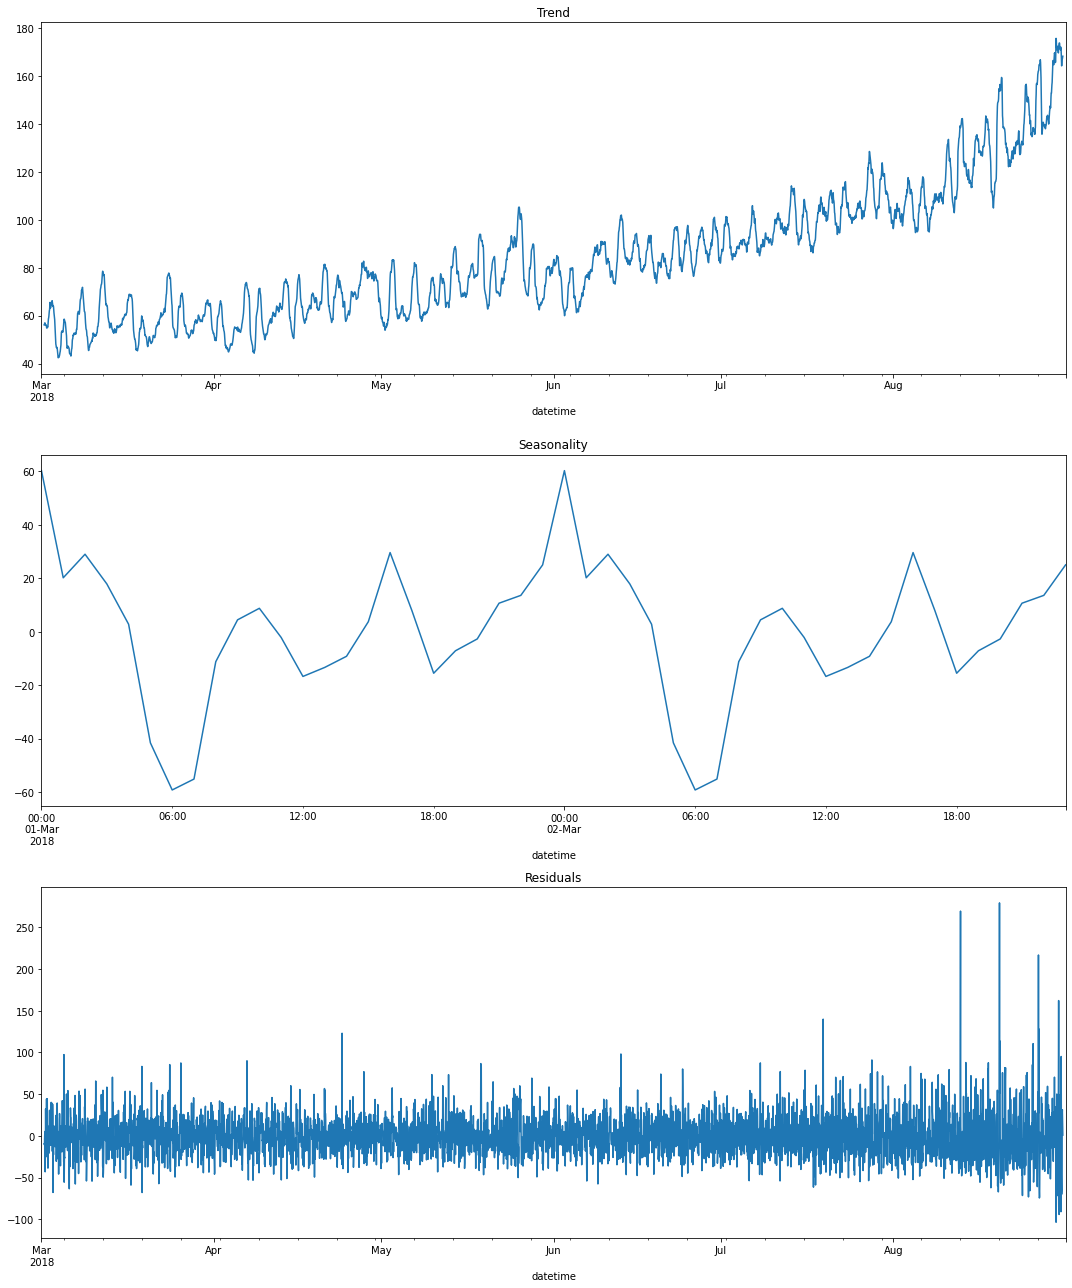

In [155]:
# создадим графики: тренда, сезонности (по часам) и остатка
plt.figure(figsize=(15, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-02 23:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Вывод:** Нам удалось декомпозировать датасет на тренд, сезонность и остаток. Как мы можем видеть на графике: сезонность больше всего проявляется в вечерние и ночные часы.

## Обучение

In [156]:
# подготовим функцию, которая будет создавать календарные, отстающие признаки и добавлять признак скользящего среднего
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [157]:
# применим функцию к датасету с ресемплингом
make_features(df_res, 10, 10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


In [158]:
# применим TimeSeriesSplit для кроссвалидации
tscv = TimeSeriesSplit(n_splits=10)

In [159]:
# разделим данные на тренировочную и тестовую выборки
train, valid = train_test_split(df_res, shuffle=False, test_size=0.2, random_state = 25)
train = train.dropna()
valid, test = train_test_split(valid, shuffle=False, test_size=0.5, random_state = 25)

In [160]:
print(train.shape)
print(valid.shape)
print(test.shape)

(3522, 14)
(442, 14)
(442, 14)


In [161]:
feat_train = train.drop('num_orders', axis=1)
targ_train = train['num_orders']

feat_valid = valid.drop('num_orders', axis=1)
targ_valid = valid['num_orders']

feat_test = test.drop('num_orders', axis=1)
targ_test = test['num_orders']

### Модель LinearRegression

In [162]:
# найдём лучшие параметры и обучим модель
parameters_LR = {'normalize':[True, False], 'fit_intercept':[True, False], 'copy_X': [True, False],
               'n_jobs': [-1, None, 1], 'positive': [True, False]}
model_LR = LinearRegression()
grid_LR = GridSearchCV(estimator=model_LR, param_grid=parameters_LR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_LR.fit(feat_train, targ_train)
predicted_LR = grid_LR.predict(feat_valid)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [163]:
print('RMSE модели LinearRegression:', mean_squared_error(targ_valid, predicted_LR)**0.5)

RMSE модели LinearRegression: 42.2404527497405


### Модель RandomForestRegressor

In [164]:
# найдём лучшие параметры и обучим модель
parameters_RFR = {'n_estimators':[5, 10, 20], 'max_depth':[5, 15, None], 'n_jobs': [-1, None, 1], 
                  'warm_start':[True, False], 'random_state':[25]}
model_RFR = RandomForestRegressor()
grid_RFR = GridSearchCV(estimator=model_RFR, param_grid=parameters_RFR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_RFR.fit(feat_train, targ_train)
predicted_RFR = grid_RFR.predict(feat_valid)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [165]:
print('RMSE модели RandomForestRegressor:', mean_squared_error(targ_valid, predicted_RFR)**0.5)

RMSE модели RandomForestRegressor: 33.042284631648975


### Модель DecisionTreeRegressor

In [166]:
# найдём лучшие параметры и обучим модель
parameters_DTR = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
                  'splitter':['best', 'random'], 'max_depth':[15, 30, None], 'random_state':[25]}
model_DTR = DecisionTreeRegressor()
grid_DTR = GridSearchCV(estimator=model_DTR, param_grid=parameters_DTR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_DTR.fit(feat_train, targ_train)
predicted_DTR = grid_DTR.predict(feat_valid)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [167]:
print('RMSE модели DecisionTreeRegressor:', mean_squared_error(targ_valid, predicted_DTR)**0.5)

RMSE модели DecisionTreeRegressor: 39.65802654507314


**Вывод:** Разбив данные на тренировочную и обучающую выборки, и проведя создание нескольких моделей машинного обучения, мы можем сказать, что наилучший результат в обучении показала модель "случайного леса" - RandomForestRegressor. RMSE модели составил 33 .

## Тестирование

In [168]:
frames = [feat_train, feat_valid]
feat = pd.concat(frames)
frames1 = [targ_train, targ_valid]
targ = pd.concat(frames1)

In [169]:
# проведем тестирование нашей лучшей модели на 10% тестовых данных
grid_RFR.fit(feat, targ)
predicted_RFR_test = grid_RFR.predict(feat_test)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [170]:
print('RMSE модели RandomForestRegressor на тесте:', mean_squared_error(targ_test, predicted_RFR_test)**0.5)

RMSE модели RandomForestRegressor на тесте: 46.79478865723311


**Вывод:** Таким образом на тестовых данных, наилучшая модель - RandomForestRegressor, показала значение 46.79, что меньше 48, как того и требовало условие задачи.